
<p style="text-align: center;"><font size=6>Курсовая работа<Big></font>
    
<p style="text-align: center;"><font size=5>Оценка ошибок самонаведения ракеты на маневрирующую цель.<Big></font>
<p style="text-align: center;"><font size=3><i>Хромов Алексей 715а гр.<i><Big></font>



































##  Постановка задачи.
Работа выполняется методом математичесского моделирования


In [1]:
# standard imports\n",
import os
import random
import numpy as np
import math

import matplotlib.pyplot as plt
%matplotlib inline

default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.6

PI = math.pi

Для начала рассмотрим передаточные функции и дифференциальные уравнения, которым они соотвествуют. Интегрирующее звено

$$W_\text{кин}(s)=\frac{1}{s}\qquad\Rightarrow\qquad 
\frac{dU_{out}(t)}{dt}=U_{in}(t)\qquad\Rightarrow\qquad 
U_{out}(t)=\int\limits_0^tU_{int}(\tau)\,d\tau;$$

тогда для

$$W_\text{кин}(s)=\frac{1}{s^2}\qquad\Rightarrow\qquad 
\frac{d^2U_{out}(t)}{dt^2}=U_{in}(t)\qquad\Rightarrow\qquad 
U_{out}(t)=\int\limits_0^t\int\limits_0^{\tau_2}U_{int}(\tau_1)\,d\tau_1\,d\tau_2.$$

Форсирующее звено:

$$W_\text{фор}(s)=\frac{(1+\tau s)}{\tau D}\qquad\Rightarrow\qquad 
U_{out}(t)=\left(U_{int}(t)+\tau\frac{dU_{int}(t)}{dt}\right)/(\tau D).
$$

Контур углового сопровождения:

$$d=\frac{\Delta\omega_0}{\Delta\theta}=\frac{U_{out}(t)}{U_{int}(t)}\qquad\Rightarrow\qquad U_{out}(t)=U_{int}(t)\cdot d$$


Блок сигнала на вход САУ - ускорение цели:
$N = 7$

Тогда ускорение цели:
$Wy = 10\dot N = 70$ м$/$сек$^2$

In [2]:
def signal_Wy(t, dt):
    N = 7
    sig = 10*N
    return sig

Блок интегратора:$$U_{out}(t)=\int\limits_0^tU_{int}(\tau)\,d\tau;$$

In [3]:
'''
        integrator
'''
def integrator(sum_out, sum_in, dt):
    sum_out += sum_in * dt
    return sum_out

Блок угловой скорости:$$U_{out}(t)=\left(U_{int}(t)+\tau\frac{dU_{int}(t)}{dt}\right)/(\tau D).
$$

Формирует сигнал угловой скорости, необходимой для полного разворота в сторону моневра цели.

In [4]:
'''
        (1 + tau * s)/(tau * D)
'''
def operator_tau_D(h, dh_dt, t):
    tau0 = 10 # время до втсречи с ракетой
    V0=1500
    D = V0*(tau-t) # дальность между ракетой и целью
    w = (h + (tau-t) * dh_dt)/((tau-t) * D)
    return w


Блок дискретизации сигнала:

In [5]:
def sampling(signal, t):
    T = 0.1
    if (t*10) % (T*10) == 0:
        signal_samp = signal
    else:
        signal_samp = 0
        
    return signal_samp, T

Блок усиления входного сигнала:

In [23]:
def corner_tracking(signal, d):
    w = d*signal
    return w

Блок экстраполятор:

In [24]:
def extrapolator(signal_samp, signal_buf, t, dt, T):
    if ((t-dt)*10) % (T*10) == 0:
        signal = signal_samp
        signal_buf = signal_samp
    else:
        signal = signal_buf
        
    return signal, signal_buf

Блок обратной связи, включающий шум и дискретизатор

In [8]:
def modul_T(phi, alpha, d, t_i):
    
    delta_alpha = random.normalvariate(0, 0.001)
        
    delta = phi - alpha + delta_alpha
        
    delta_sampl, T = sampling(delta, t_i)
    
    return delta_sampl, T

Блок гиростабилизатора: 
- экстраполятор 
- интегратор

In [9]:
def gyrostabilizer(alpha, w_0, w_0_buf, dt, t, T):
    
    w_0_ext, w_0_buf = extrapolator(w_0, w_0_buf, t, dt, T)
    alpha = integrator(alpha, w_0_ext, dt)
    
    return alpha, w_0_buf

Блок уравнения z- преобразования:

In [10]:
def module_Z_F(dw0, lambd_prev, T, T2, n):
    V0 = 1500

    return (n*V0*dw0 + T2/T*lambd_prev) / (1 + T2/T)
    
    

Блок решения уравнения z- преобразования методом Эйлера:
$$\frac{dw}{dt} = \frac{w_{i+1}-w_{i}}{T}$$
$$\lambda_{i+1} = \lambda_{i} + T \cdot Fz(dw/dt, \lambda_{i}, T, T2, n) $$

In [11]:
def module_Z(w0, w0_prev, lambd_prev, T, T2, n):
    dw0 = (w0 - w0_prev)/T
    lambd = lambd_prev + T * module_Z_F(dw0, lambd_prev, T, T2, n)
    
    return lambd

Блок нелинейного преобразования - ограничитель для физической модели ускорителя ракеты.

In [12]:
def nolinear(lambd):
    L=200
    if lambd > L:
        lambd = L
        
    if lambd < -L:
        lambd = -L
        
    return lambd

Блок бортовой цифровой вычислительной машины:
    
- блок усилителя
- блок z-преобразования
- блок нелинейного преобразования

In [13]:
def board_digital_computer(delta_sampl, t, T, lambd_prev, w0_prev, d, T2, n):
    
    w0 = corner_tracking(delta_sampl, d)
    
    lambd = module_Z(w0, w0_prev, lambd_prev, T, T2, n)
    lambd0 = nolinear(lambd)
    
    
    return lambd0, w0, lambd

Блок уравнения стабилизации:
$$\frac{\lambda_0 - W_p-2\xi T_k\dot{W}_p}{T_k^2}$$

In [14]:
def stabilization_loop_S_F(lambd0, Wr, dWr):
    
    ksi = 0.7
    Tk=0.2
    
    return (lambd0 - Wr - 2*ksi*Tk*dWr)/(Tk**2)

Блок решения уравнения стабилизации итерационным методом Рунге Кутта второго порядка.
Прогноз:

$$\dot{Wr}_{i+1}=\dot{Wr}_{i}+dt\cdot Fs(\lambda, Wr_i, \dot{Wr}_i)$$

$$Wr_{i+1} = Wr_i + dt * \dot{Wr}_{i+1}$$

Коррекция:

$$\widetilde{\dot{Wr}}_{i+1}=\dot{Wr}_{i}+dt\cdot \frac{Fs(\lambda, Wr_{i+1}, \dot{Wr}_{i+1})+Fs(\lambda, Wr_i, \dot{Wr}_i)}{2}$$

$$\widetilde{Wr}_{i+1} = Wr_i + dt * \widetilde{\dot{Wr}}_{i+1}$$

In [15]:
def stabilization_loop_S(lambd0, Wr, dot_Wr, dt):
    
    #predict
    dot_Wr_next = dot_Wr + dt * stabilization_loop_S_F(lambd0, Wr, dot_Wr)
    
    Wr_next = Wr + dt * dot_Wr_next
    
    #correction
    dot_Wr_next = dot_Wr + dt * (stabilization_loop_S_F(lambd0, Wr, dot_Wr) + stabilization_loop_S_F(lambd0, Wr_next, dot_Wr_next))/2
    
    Wr_next = Wr + dt * dot_Wr_next
    
    
    
    return Wr_next, dot_Wr_next

Блок контура стабилизации:

- блок экстраполятора
- блок стабилизации

In [16]:
def stabilization_loop(lambd0, lambd0_buf, Wr, dot_Wr, dt, t, T):
    
    lambd0, lambd0_buf = extrapolator(lambd0, lambd0_buf, t, dt, T)
    
    Wr_next, dot_Wr_next = stabilization_loop_S(lambd0, Wr, dot_Wr, dt)
    
    
    return Wr_next, lambd0_buf, dot_Wr_next

In [17]:
def schematic_model(t, d, T2, n, t_scale = 1000):
    
    data_out0 = []
    data_out1 = []
    data_out2 = []
    data_out3 = []
    data_out4 = []
    data_out5 = []
    data_out6 = []
    
    
    
    y_target = 0
    speed_target = 0
    
    
    alpha=0
    phi = 0
    lambd_prev=0
    w0=0
    w0_buf=0
    lambd0=0
    lambd0_buf=0
    y_rocket= 0
    speed_rocket= 0
    Wr = 0
    dot_Wr = 0
    
    
     
    for i in range(t*t_scale):
        t_i = i/t_scale
        dt_i = 1/t_scale
        
        Wy = signal_Wy(t_i, dt_i)
        
        '''
            integrator
        '''
        speed_target = integrator(speed_target, Wy, dt_i)
        y_target = integrator(y_target, speed_target, dt_i)
        
            
            
        h = y_target - y_rocket
        
        w = operator_tau_D(h, speed_target - speed_rocket, t_i)
            
        
        
        '''
                integrator
        '''
        phi = integrator(phi, w, dt_i)
        
        delta_sampl, T = modul_T(phi, alpha, d, t_i)
        
        if (t_i*10) % (T*10) == 0:
                lambd0, w0, lambd_prev = board_digital_computer(delta_sampl, t_i, T, lambd_prev, w0, d, T2, n)
                
        alpha, w0_buf = gyrostabilizer(alpha, w0, w0_buf, dt_i, t_i, T)
        
        Wr, lambd0_buf, dot_Wr = stabilization_loop(lambd0, lambd0_buf, Wr, dot_Wr, dt_i, t_i, T)
        '''
                integrator
        '''
            
        speed_rocket = integrator(speed_rocket, Wr, dt_i)
        y_rocket = integrator(y_rocket, speed_rocket, dt_i)
            
            
        
        
        
        data_out0.append(y_target-y_rocket)
        data_out1.append(y_target)
        data_out2.append(y_rocket)
        data_out3.append(speed_target)
        data_out4.append(speed_rocket)
        data_out5.append(Wy)
        data_out6.append(Wr)
        
    return data_out0, data_out1, data_out2, data_out3, data_out4, data_out5, data_out6
        

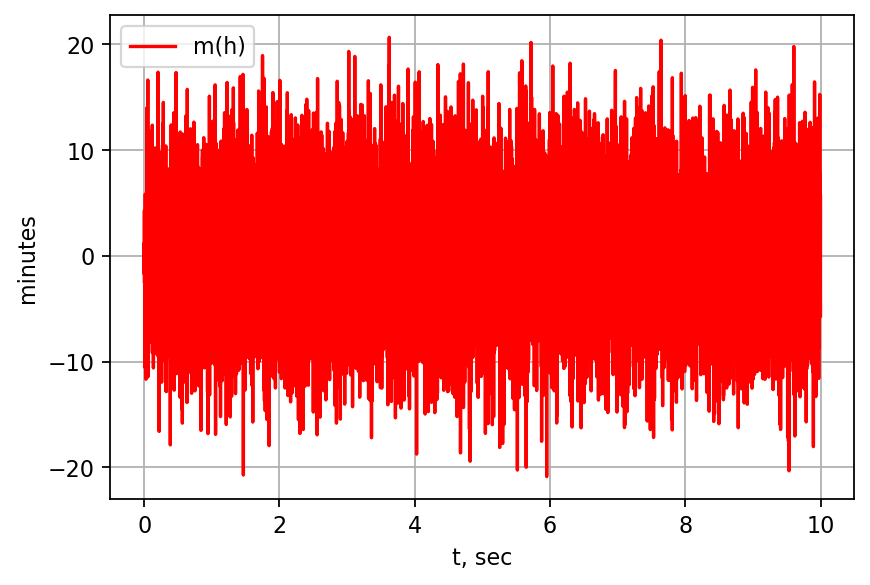

In [26]:
data_out = []
for i in range(tau*1000):
    t_i=i/1000
    data_out.append(random.normalvariate(0, 0.1)*60)
    
plt.ylabel('minutes')
plt.xlabel('t, sec')
plt.plot(data_time, data_out, label = u'm(h)', color = 'r')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
tau = 10 #10 sec
t_scale = 1000
d = 5#5
T2 = 0.003#0.0001
n = 5#20
final_load_teat = 100

data_h = np.zeros((final_load_teat, tau*t_scale))
data_y_target = np.zeros((final_load_teat, tau*t_scale))
data_y_rocket = np.zeros((final_load_teat, tau*t_scale))
data_speed_target = np.zeros((final_load_teat, tau*t_scale))
data_speed_rocket = np.zeros((final_load_teat, tau*t_scale))
data_Wy = np.zeros((final_load_teat, tau*t_scale))
data_Wr = np.zeros((final_load_teat, tau*t_scale))


for i in range(final_load_teat):
    h, y_target, y_rocket, speed_target, speed_rocket, Wy, Wr = schematic_model(tau, d, T2, n, t_scale)
    
    data_h[i] = h
    data_y_target[i] = y_target
    data_y_rocket[i] = y_rocket
    data_speed_target[i] = speed_target
    data_speed_rocket[i] = speed_rocket
    data_Wy[i] = Wy
    data_Wr[i] = Wr

#data_h = np.array(data_h)
MEAN_h = np.zeros(tau*t_scale)
MEAN_y_target = np.zeros(tau*t_scale)
MEAN_y_rocket = np.zeros(tau*t_scale)
MEAN_speed_target = np.zeros(tau*t_scale)
MEAN_speed_rocket = np.zeros(tau*t_scale)
MEAN_Wy = np.zeros(tau*t_scale)
MEAN_Wr = np.zeros(tau*t_scale)
DEV_h = np.zeros(tau*t_scale)

for i in range(tau*t_scale):
    MEAN_h[i] = sum(data_h[::,i])/final_load_teat
    MEAN_y_target[i] = sum(data_y_target[::,i])/final_load_teat
    MEAN_y_rocket[i] = sum(data_y_rocket[::,i])/final_load_teat
    MEAN_speed_target[i] = sum(data_speed_target[::,i])/final_load_teat
    MEAN_speed_rocket[i] = sum(data_speed_rocket[::,i])/final_load_teat
    MEAN_Wy[i] = sum(data_Wy[::,i])/final_load_teat
    MEAN_Wr[i] = sum(data_Wr[::,i])/final_load_teat
    DEV_h[i] = np.sqrt(sum((MEAN_h[i] - data_h[::,i])**2)/final_load_teat)


    
    
print(MEAN_h[-1])
data_time = tau - np.arange(0, tau, 1/t_scale)

0.6991419734860392


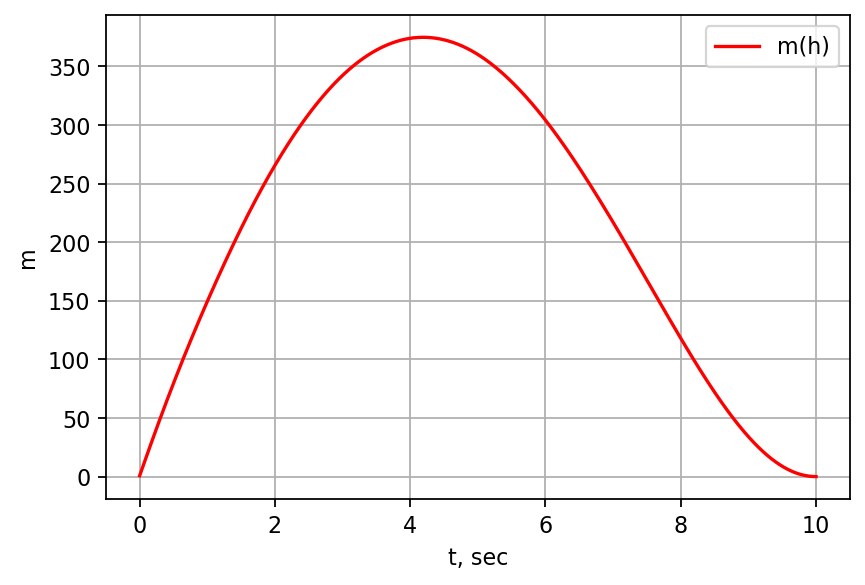

In [27]:
plt.ylabel('m')
plt.xlabel('t, sec')
plt.plot(data_time, MEAN_h, label = u'm(h)', color = 'r')
plt.legend()
plt.grid(True)
plt.show()

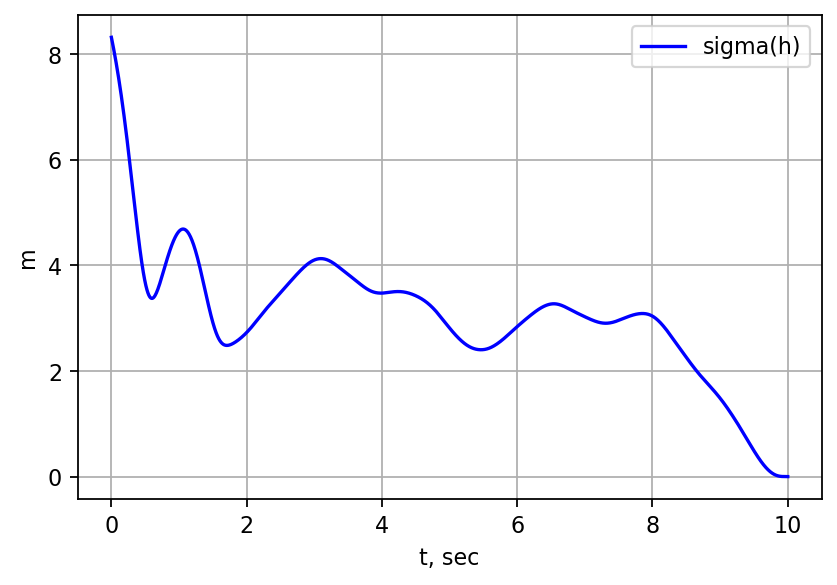

In [28]:
plt.ylabel('m')
plt.xlabel('t, sec')
plt.plot(data_time, DEV_h, label = u'sigma(h)', color = 'b')
plt.legend()
plt.grid(True)
plt.show()

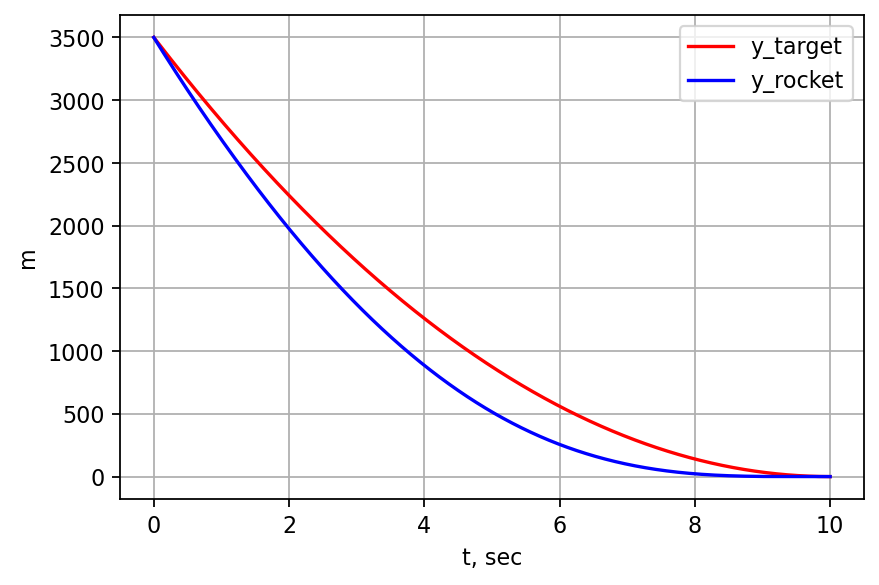

In [29]:
plt.ylabel('m')
plt.xlabel('t, sec')
plt.plot(data_time, MEAN_y_target, label = u'y_target', color = 'r')
plt.plot(data_time, MEAN_y_rocket, label = u'y_rocket', color = 'b')
plt.legend()
plt.grid(True)
plt.show()

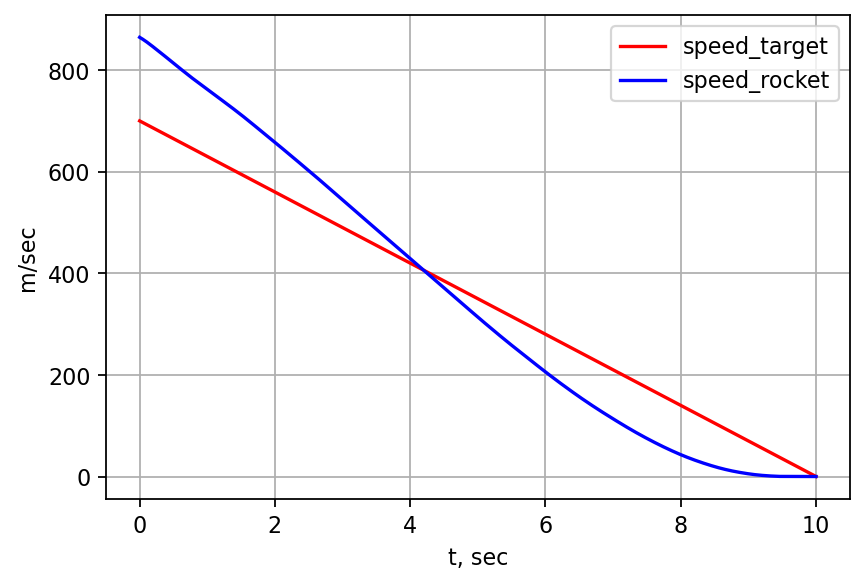

In [30]:
plt.ylabel('m/sec')
plt.xlabel('t, sec')
plt.plot(data_time, MEAN_speed_target, label = u'speed_target', color = 'r')
plt.plot(data_time, MEAN_speed_rocket, label = u'speed_rocket', color = 'b')
plt.legend()
plt.grid(True)
plt.show()

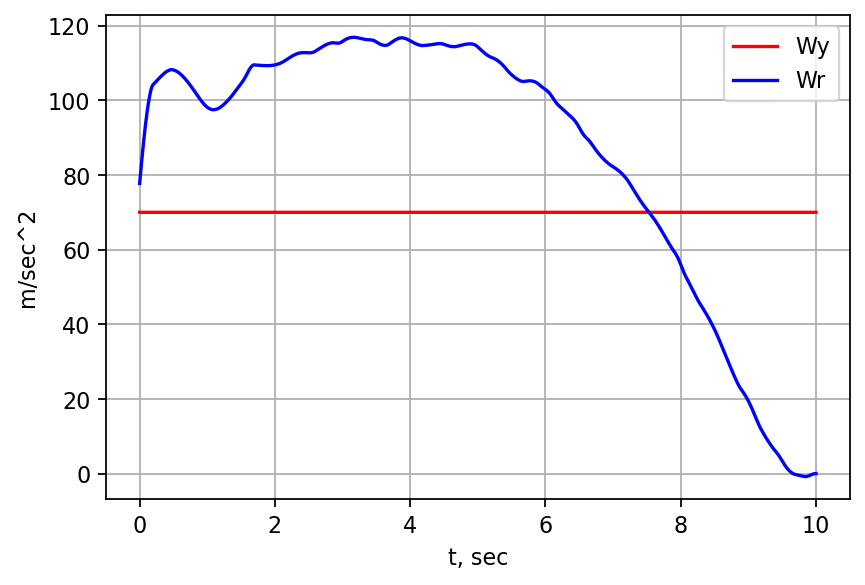

In [31]:
plt.ylabel('m/sec^2')
plt.xlabel('t, sec')
plt.plot(data_time, MEAN_Wy, label = u'Wy', color = 'r')
plt.plot(data_time, MEAN_Wr, label = u'Wr', color = 'b')
plt.legend()
plt.grid(True)
plt.show()

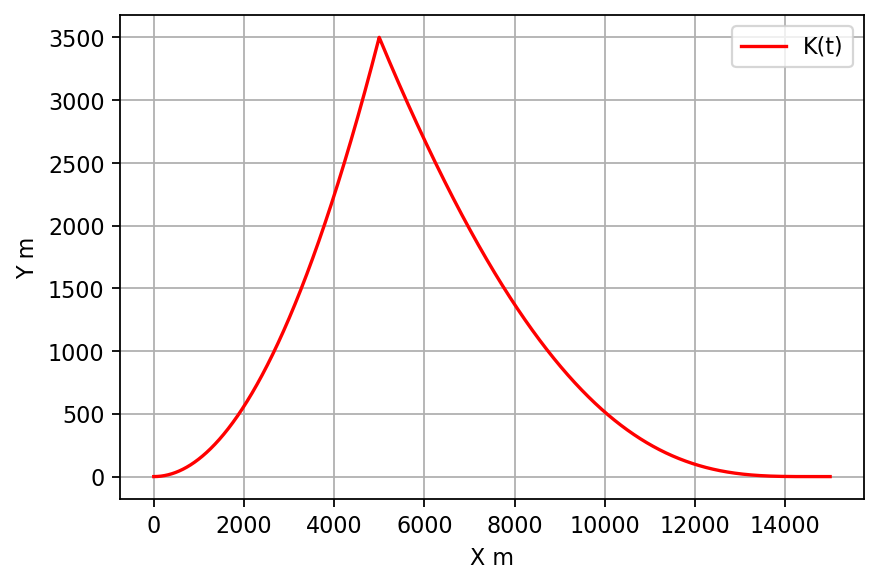

In [22]:
data_coord = []
SS = 0
for t_i in range(tau*t_scale):
    t_i/=t_scale
    Vy=500
    SS=Vy*t_i
    data_coord.append(Vy*t_i)
    
data_U = MEAN_y_target.copy()

for t_i in range(tau*t_scale):
    data_U = np.append(data_U, MEAN_y_rocket[tau*t_scale - t_i - 1])
    t_i/=t_scale
    Vr=1000
    data_coord.append(SS+Vr*t_i)
    
    
    
    
    
plt.ylabel('Y m')
plt.xlabel('X m')
plt.plot(data_coord, data_U, label = u'K(t)', color = 'r')
plt.legend()
plt.grid(True)
plt.show()